# Data Science Assignement Part 1

#### First, we must define the structure of our dataset (see the report file for detailed specifications). 
#### Then, we proceed to implement the code for scraping and crawling data from the website.

#### Before implementing the code, it is necessary to install and import all required dependencies.

In [1]:
%pip install beautifulsoup4
%pip install selenium
%pip install requests
%pip install pandas
%pip install matplotlib
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\Giannis\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\Giannis\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\Giannis\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\Giannis\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\Giannis\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\Giannis\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import concurrent.futures
import ast
from itertools import combinations
from collections import Counter
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup

#### Having installed and imported all the necessary dependencies, we can now proceed with the implementation of the web crawler. Through website exploration, we identified that the "Αποφάσεις" section redirects to "https://areiospagos.gr/nomologia/apofaseis.asp", which serves as the source for our data collection.

In [27]:
# Set up headless Chrome
chrome_options = Options()
chrome_options.add_argument('--headless')
driver = webdriver.Chrome(options=chrome_options)

# Load the page
url = "https://areiospagos.gr/nomologia/apofaseis.asp"
driver.get(url)

# Find year input field and submit the form for year=2024
year_input = driver.find_element(By.NAME, "x_ETOS")
year_input.clear()
year_input.send_keys("2024")
submit_button = driver.find_element(By.NAME, "submit_krit")
submit_button.click()
time.sleep(1)  

# Find all the decisions links
link_elements = driver.find_elements(By.XPATH, "//a[contains(@href, 'apofaseis_DISPLAY.asp')]")
links = [link.get_attribute("href") for link in link_elements]
print(f"Found {len(links)} decision links.")

# Close Selenium browser
driver.quit()

# Create a single session for all requests
session = requests.Session()

# Compile regex matchers
re_title = re.compile(r"(\d{1,4}/\d{4})\s?\((.*?)\s*-\s*(.*?)\)")
re_judges = re.compile(r"(Συγκροτήθηκε|ΣΥΓΚΡΟΤΗΘΗΚΕ) από τους (δικαστές|Δικαστές)(:|,) (.*?) Αρεοπαγίτες")
re_intro = re.compile(r"ΤΟ ΔΙΚΑΣ.*?(?=ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ)", re.DOTALL)
re_main = re.compile(r"ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ.*?(?=ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ)", re.DOTALL)
re_concl = re.compile(r"ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ.*?(?=<< Επιστροφή)", re.DOTALL)
re_all_articles = re.compile(
    r"""
    \(? 
    (?:
        # Article then code
        (?:(?:του|των)\s+)?άρθ(?:ρο|ρα|ρ\.?)\s+
        (?P<articles1>
            \d+(?:\s*παρ\.\s*\d+)?                              # single article or with paragraph
            (?:\s*(?:,|και)\s*\d+(?:\s*παρ\.\s*\d+)?)*          # additional articles
        )
        \s+(?:του\s+)?(?P<code1>ΠΚ|ΚΠΔ|ΑΚ|ΚΠολΔ)

        |
        # Code then atricle
        (?P<code2>ΠΚ|ΚΠΔ|ΑΚ|ΚΠολΔ)\s+
        (?P<articles2>
            \d+(?:\s*παρ\.\s*\d+)?                              
            (?:\s*(?:,|και)\s*\d+(?:\s*παρ\.\s*\d+)?)* 
        )
    )
    \)? 
    """,
    re.IGNORECASE | re.VERBOSE
)

re_all_articles_cleaned = re.compile(
    r"""
    (?:
        # Match standalone article numbers with optional "παρ." after them
        (?<!\d)                          
        (?P<article>\d+)               
        (?:\s*παρ\.\s*\d+)?            
        (?!\d)                          
    )
    """,
    re.IGNORECASE | re.VERBOSE
) 

# Function to extract the decision data
def extract_decision_data(url):
    response = session.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    text = soup.text

    # Extract decision, year, department_type and department_number
    title = soup.find('title').text
    match = re_title.search(title)
    if match:
        decision_number = match.group(1)
        year = match.group(1).split('/')[1]
        department_type = match.group(2)
        department_number = match.group(3)
    else:
        decision_number, year, department_type, department_number = None, None, None, None

    # Extract judges as list
    judge_match = re_judges.search(text)
    if judge_match:
        judges_text = judge_match.group(4).strip()
        judges_text = judges_text.replace('και', ',')
        judges = [name.strip() for name in judges_text.split(',') if len(name.split()) > 1]
        exclusion_phrases = ["Προεδρεύοντα Αρεοπαγίτη", "Αντιπρόεδρο του Αρείου Πάγου"]
        judges = [judge for judge in judges if not any(phrase in judge for phrase in exclusion_phrases)]
    else:
        judges = None

    # Extract introduction text
    intro_match = re_intro.search(text)
    introduction_text = intro_match.group(0).strip().replace('\n', ' ') if intro_match else None

    # Extract main text
    main_match = re_main.search(text)
    main_text = main_match.group(0).strip().replace('\n', ' ') if main_match else None

    # Extract conclusion text
    concl_match = re_concl.search(text)
    conclusion_text = concl_match.group(0).strip().replace('\n', ' ') if concl_match else None

    # Extract legal references
    def extract_clean_articles(article_str):
        parts = re.split(r",|\sκαι\s", article_str)
        return [
            m.group("article")
            for part in parts
            if (m := re_all_articles_cleaned.search(part.strip()))
        ]

    # Combine text
    full_text = f"{introduction_text or ''} {main_text or ''} {conclusion_text or ''}"

    # Create sets for each code type
    pk_articles, kpd_articles, ak_articles, kpol_articles = set(), set(), set(), set()
    code_sets = {
        "ΠΚ": pk_articles,
        "ΚΠΔ": kpd_articles,
        "ΑΚ": ak_articles,
        "ΚΠΟΛΔ": kpol_articles,
    }

    # Loop through matches
    for match in re_all_articles.finditer(full_text):
        code = (match.group("code1") or match.group("code2") or "").upper()
        articles = match.group("articles1") or match.group("articles2")
        if not (code and articles and code in code_sets):
            continue
        clean_articles = extract_clean_articles(articles)
        code_sets[code].update(clean_articles)

    # Return extracted data
    return {
        'decision_number': decision_number,
        'year': int(year) if year else None,
        'department': department_type,
        'department_number': department_number,
        'judges': judges,
        'introduction_text': introduction_text,
        'main_text': main_text,
        'conclusion_text': conclusion_text,
        'penal_code': pk_articles if pk_articles else None,
        'code_of_criminal_procedure': kpd_articles if kpd_articles else None,
        'civil_code': ak_articles if ak_articles else None,
        'code_of_civil_procedure': kpol_articles if kpol_articles else None,
        'decision_link': url
    }

# Extract data for every decision concurrently
decisions = []
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    future_to_url = {executor.submit(extract_decision_data, url): url for url in links}
    
    for idx, future in enumerate(concurrent.futures.as_completed(future_to_url), start=1):
        url = future_to_url[future]
        try:
            data = future.result()
            decisions.append(data)
            print(f"Processed decision {idx}/{len(links)}")
        except Exception as exc:
            print(f"{url} generated an exception: {exc}")

# Save the dataset
df = pd.DataFrame(decisions)
df.to_csv("decisions.csv", index=False, encoding="utf-8-sig")

Found 2475 decision links.
Processed decision 1/2475
Processed decision 2/2475
Processed decision 3/2475
Processed decision 4/2475
Processed decision 5/2475
Processed decision 6/2475
Processed decision 7/2475
Processed decision 8/2475
Processed decision 9/2475
Processed decision 10/2475
Processed decision 11/2475
Processed decision 12/2475
Processed decision 13/2475
Processed decision 14/2475
Processed decision 15/2475
Processed decision 16/2475
Processed decision 17/2475
Processed decision 18/2475
Processed decision 19/2475
Processed decision 20/2475
Processed decision 21/2475
Processed decision 22/2475
Processed decision 23/2475
Processed decision 24/2475
Processed decision 25/2475
Processed decision 26/2475
Processed decision 27/2475
Processed decision 28/2475
Processed decision 29/2475
Processed decision 30/2475
Processed decision 31/2475
Processed decision 32/2475
Processed decision 33/2475
Processed decision 34/2475
Processed decision 35/2475
Processed decision 36/2475
Processed 

#### Now that the crawler has finished, we can move on to exploring the data to ensure it meets our expectations.

In [28]:
# Load the dataset that we created 
df = pd.read_csv("decisions.csv", encoding="utf-8-sig")

# Get a summary of the dataset
print("Dataset Summary:")
print("------------------")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print("----------------")
print(df.isnull().sum())

Dataset Summary:
------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   decision_number             2470 non-null   object 
 1   year                        2470 non-null   float64
 2   department                  2470 non-null   object 
 3   department_number           2470 non-null   object 
 4   judges                      2451 non-null   object 
 5   introduction_text           2368 non-null   object 
 6   main_text                   2369 non-null   object 
 7   conclusion_text             2461 non-null   object 
 8   penal_code                  348 non-null    object 
 9   code_of_criminal_procedure  505 non-null    object 
 10  civil_code                  880 non-null    object 
 11  code_of_civil_procedure     1570 non-null   object 
 12  decision_link               2475 non-null   object 
dt

#### Overall, the data is generally as expected. There are some missing values, particularly in text and legal article fields, due to the inconsistent structure of the source content, which made it difficult for the regular expressions to capture all relevant information accurately. We can now proceed to visualize our data.

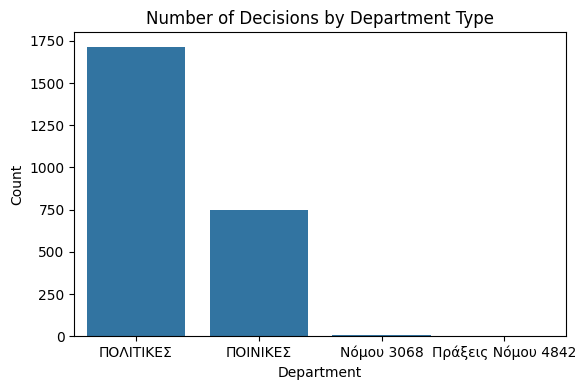

In [29]:
# 1.Count of decisions by department type
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="department", order=df["department"].value_counts().index)
plt.title("Number of Decisions by Department Type")
plt.xlabel("Department")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

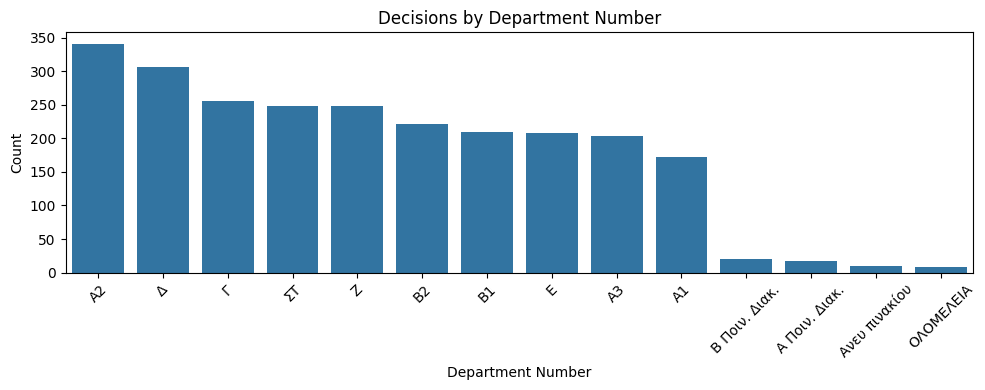

In [30]:
# 2.Number of decisions by department number
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x="department_number", order=df["department_number"].value_counts().index)
plt.title("Decisions by Department Number")
plt.xlabel("Department Number")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

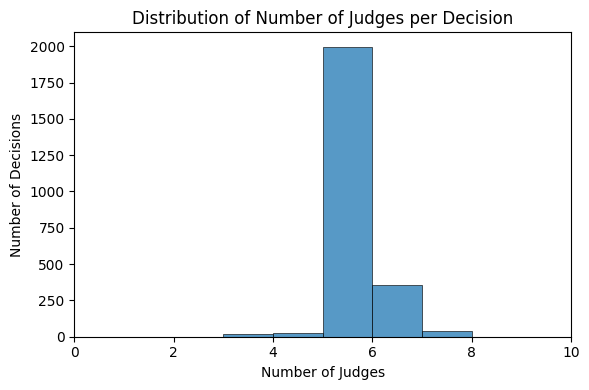

In [31]:
# 3.Distribution of number of judges per case
df["num_judges"] = df["judges"].apply(lambda x: len(eval(x)) if pd.notnull(x) else 0)

plt.figure(figsize=(6, 4))
sns.histplot(df["num_judges"], bins=range(1, df["num_judges"].max() + 2), kde=False)

plt.xlim(0, 10)  
plt.title("Distribution of Number of Judges per Decision")
plt.xlabel("Number of Judges")
plt.ylabel("Number of Decisions")
plt.tight_layout()
plt.show()

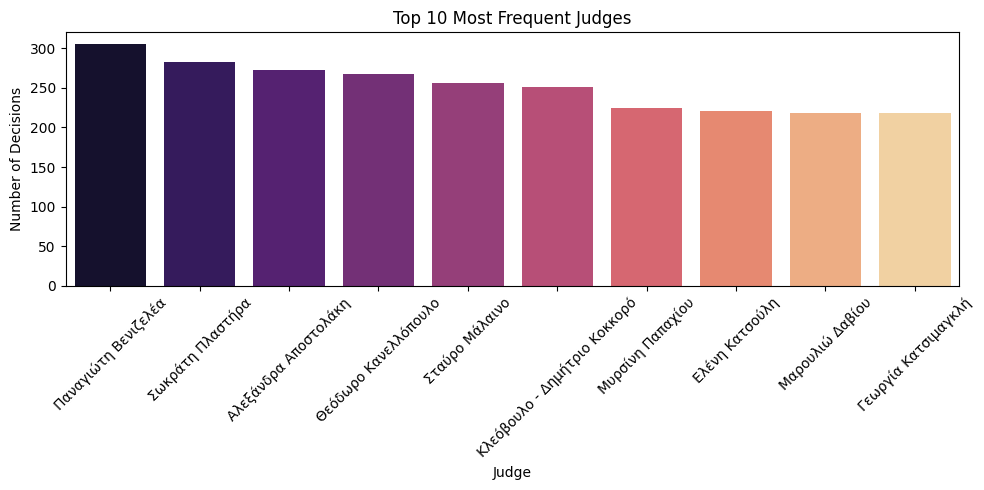

In [32]:
# 4.Top 10 most frequent judges
judge_counts = Counter()
for judges_list in df["judges"].dropna():
    for judge in eval(judges_list):
        judge_counts[judge] += 1

top_judges_df = pd.DataFrame(judge_counts.most_common(10), columns=["Judge", "Count"])

plt.figure(figsize=(10, 5))
sns.barplot(data=top_judges_df, x="Judge", y="Count", hue="Judge", palette="magma", legend=False)
plt.title("Top 10 Most Frequent Judges")
plt.xlabel("Judge")
plt.ylabel("Number of Decisions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

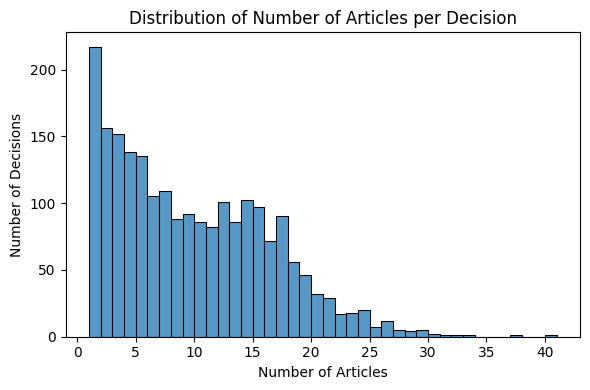

In [33]:
# 5.Distribution of the number of articles per decision
df["num_articles"] = df["penal_code"].apply(lambda x: len(eval(x)) if pd.notnull(x) else 0) + \
                      df["code_of_criminal_procedure"].apply(lambda x: len(eval(x)) if pd.notnull(x) else 0) + \
                      df["civil_code"].apply(lambda x: len(eval(x)) if pd.notnull(x) else 0) + \
                      df["code_of_civil_procedure"].apply(lambda x: len(eval(x)) if pd.notnull(x) else 0)

plt.figure(figsize=(6, 4))
sns.histplot(df["num_articles"], bins=range(1, df["num_articles"].max() + 2), kde=False)
plt.title("Distribution of Number of Articles per Decision")
plt.xlabel("Number of Articles")
plt.ylabel("Number of Decisions")
plt.tight_layout()
plt.show()

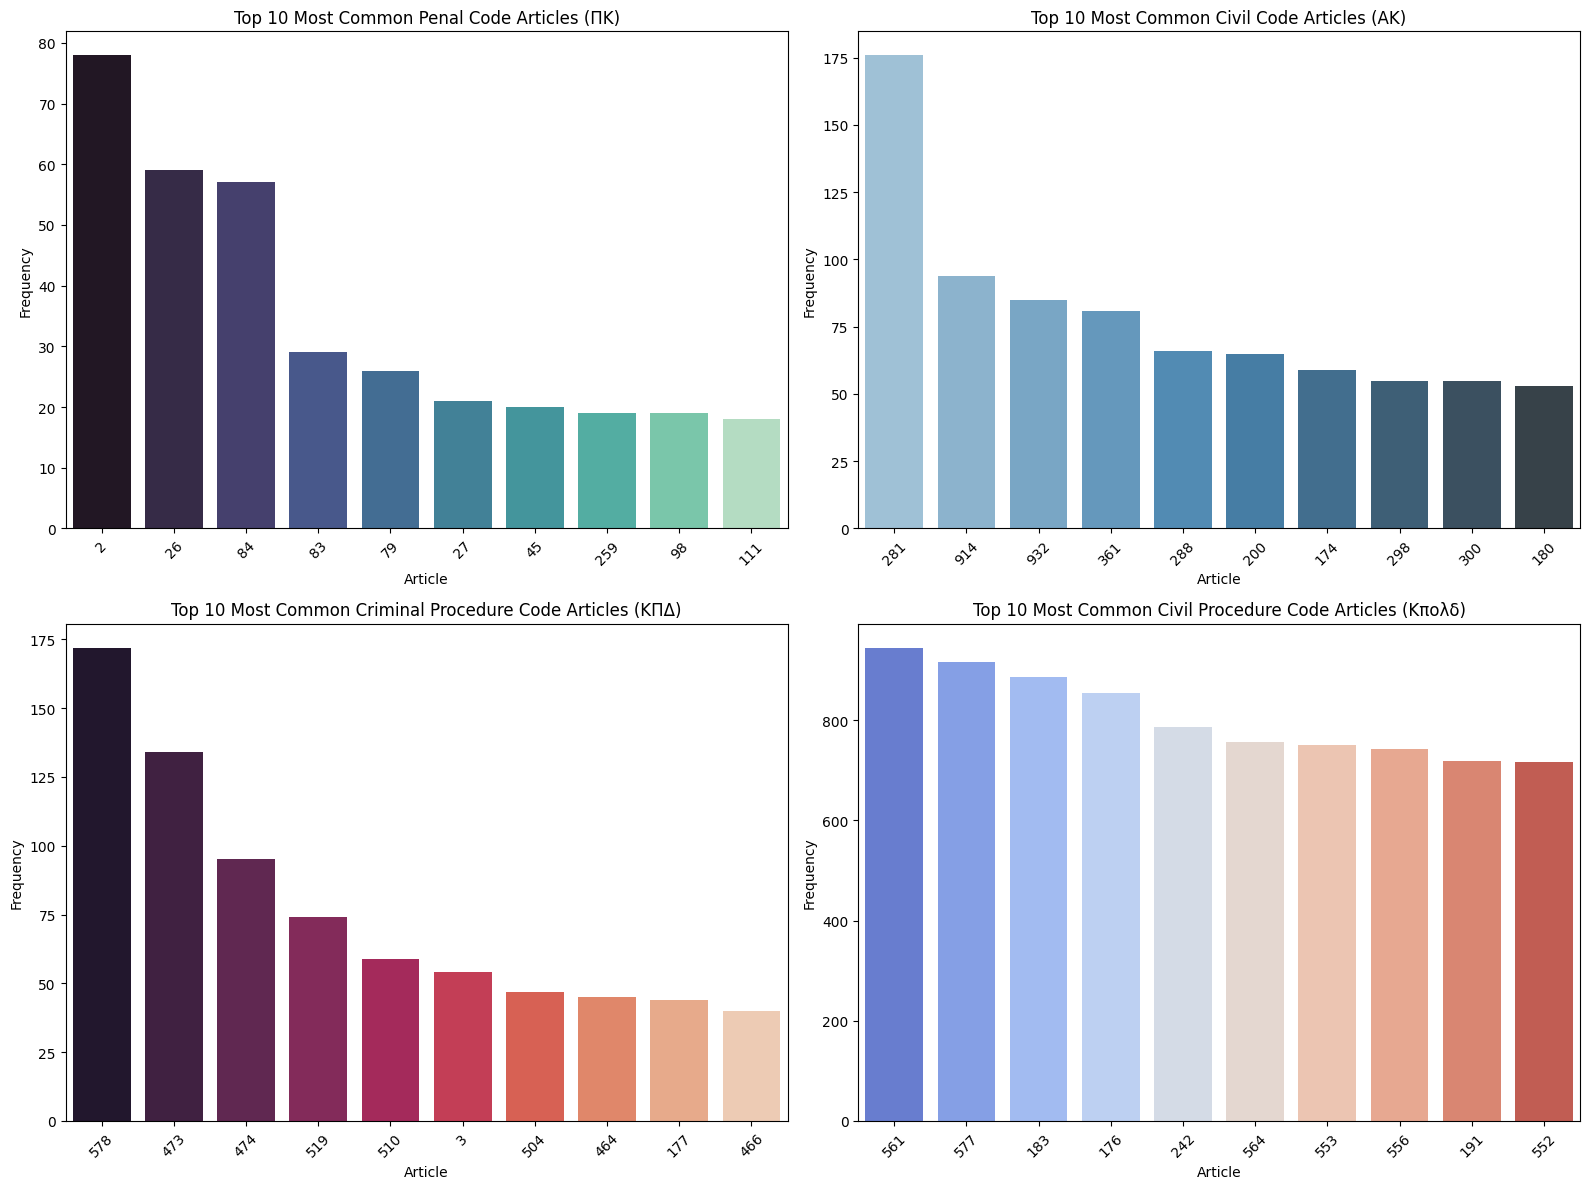

In [34]:
# 6.Top 10 most frequent articles 
def flatten_sets(column):
    all_items = []
    for row in df[column].dropna():
        items = ast.literal_eval(row) if isinstance(row, str) else row
        all_items.extend(items)
    return Counter(all_items)

# Prepare the data for each code
penal_counts = flatten_sets("penal_code")
penal_df = pd.DataFrame(penal_counts.most_common(10), columns=["Article", "Count"])

civil_counts = flatten_sets("civil_code")
civil_df = pd.DataFrame(civil_counts.most_common(10), columns=["Article", "Count"])

kpd_counts = flatten_sets("code_of_criminal_procedure")
kpd_df = pd.DataFrame(kpd_counts.most_common(10), columns=["Article", "Count"])

kpol_counts = flatten_sets("code_of_civil_procedure")
kpol_df = pd.DataFrame(kpol_counts.most_common(10), columns=["Article", "Count"])

# Create a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot each code's top 10 articles
sns.barplot(data=penal_df, x="Article", y="Count", hue="Article", palette="mako", ax=axes[0, 0], legend=False)
axes[0, 0].set_title("Top 10 Most Common Penal Code Articles (ΠΚ)")
axes[0, 0].set_xlabel("Article")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].tick_params(axis='x', rotation=45)

sns.barplot(data=civil_df, x="Article", y="Count", hue="Article", palette="Blues_d", ax=axes[0, 1], legend=False)
axes[0, 1].set_title("Top 10 Most Common Civil Code Articles (ΑΚ)")
axes[0, 1].set_xlabel("Article")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].tick_params(axis='x', rotation=45)

sns.barplot(data=kpd_df, x="Article", y="Count", hue="Article", palette="rocket", ax=axes[1, 0], legend=False)
axes[1, 0].set_title("Top 10 Most Common Criminal Procedure Code Articles (ΚΠΔ)")
axes[1, 0].set_xlabel("Article")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].tick_params(axis='x', rotation=45)

sns.barplot(data=kpol_df, x="Article", y="Count", hue="Article", palette="coolwarm", ax=axes[1, 1], legend=False)
axes[1, 1].set_title("Top 10 Most Common Civil Procedure Code Articles (Κπολδ)")
axes[1, 1].set_xlabel("Article")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

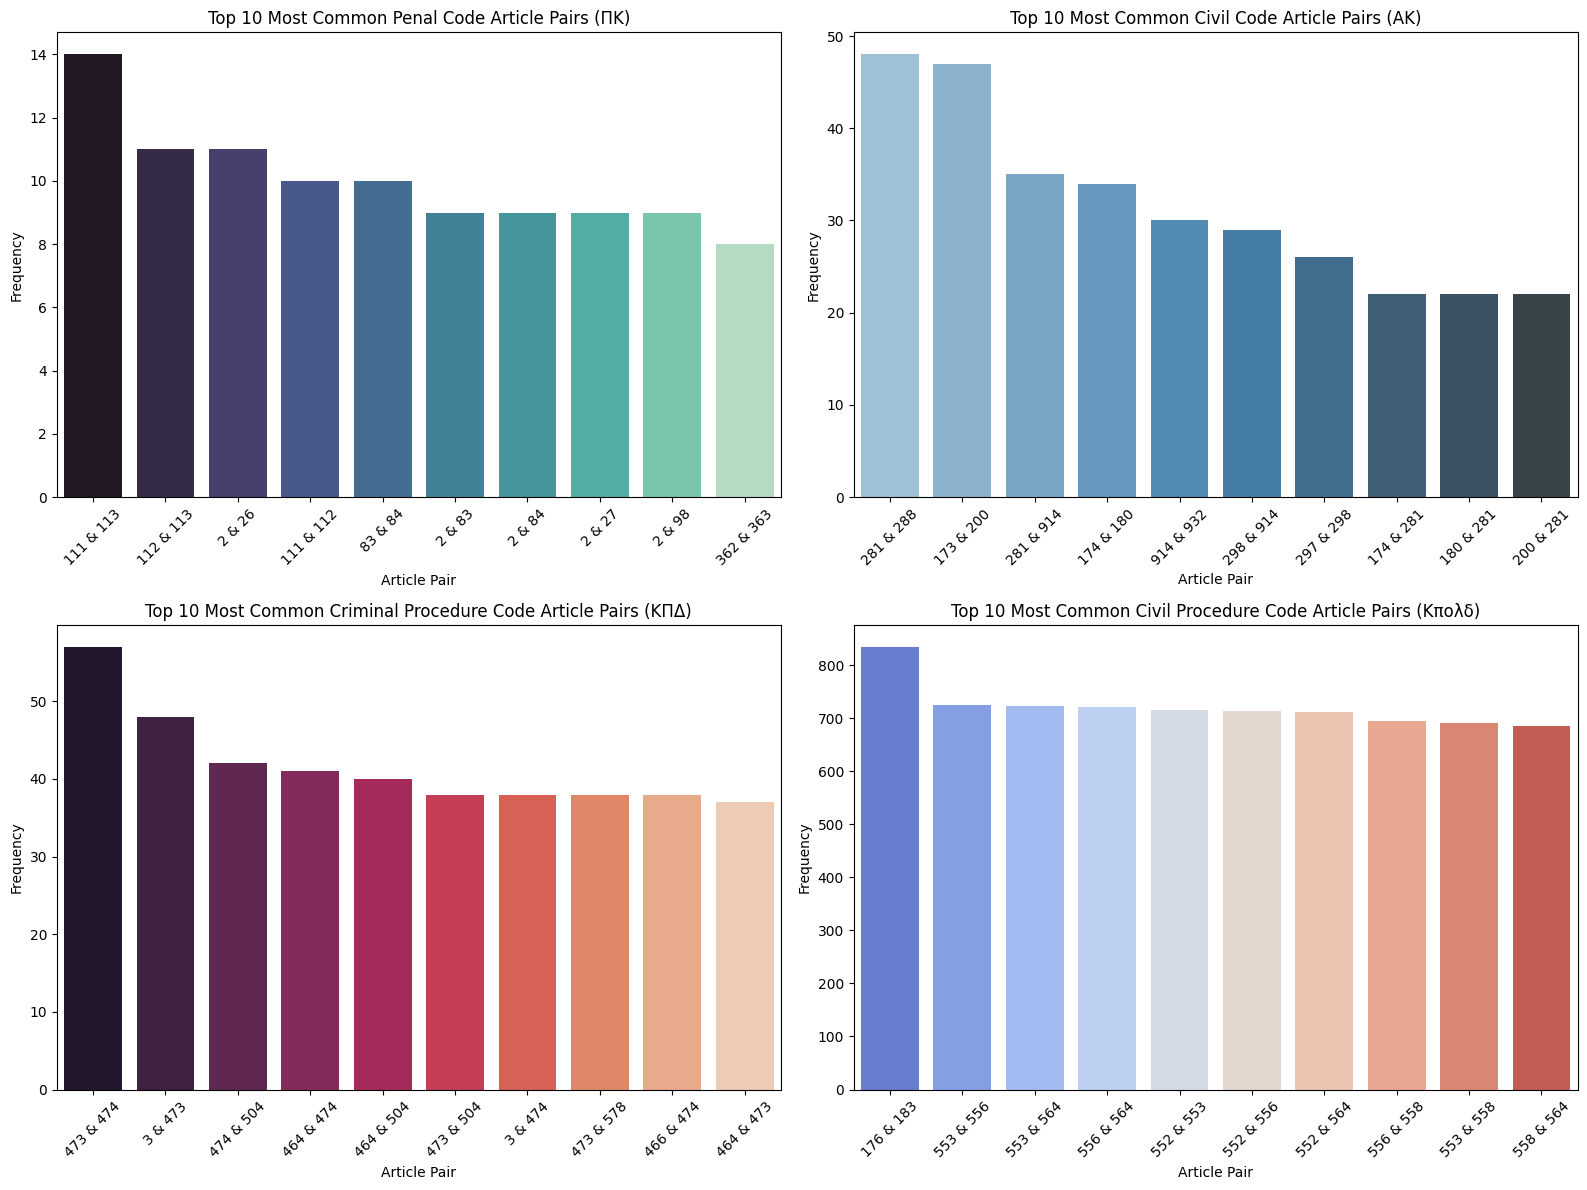

In [35]:
# 7.Top 10 most frequent article pairs 
def flatten_sets(column):
    all_items = []
    for row in df[column].dropna():
        items = ast.literal_eval(row) if isinstance(row, str) else row
        all_items.extend(items)
    return Counter(all_items)

# Function to find the most common article pairs
def get_article_pairs(column_name):
    article_pairs = Counter()
    for articles in df[column_name].dropna():
        arts = sorted(ast.literal_eval(articles))
        for combo in combinations(arts, 2):
            article_pairs[combo] += 1
    return article_pairs

# Get top 10 most common article pairs for each legal code
penal_pairs = get_article_pairs("penal_code")
penal_pairs_df = pd.DataFrame(penal_pairs.most_common(10), columns=["Pair", "Count"])
penal_pairs_df["Pair"] = penal_pairs_df["Pair"].apply(lambda x: f"{x[0]} & {x[1]}")

civil_pairs = get_article_pairs("civil_code")
civil_pairs_df = pd.DataFrame(civil_pairs.most_common(10), columns=["Pair", "Count"])
civil_pairs_df["Pair"] = civil_pairs_df["Pair"].apply(lambda x: f"{x[0]} & {x[1]}")

kpd_pairs = get_article_pairs("code_of_criminal_procedure")
kpd_pairs_df = pd.DataFrame(kpd_pairs.most_common(10), columns=["Pair", "Count"])
kpd_pairs_df["Pair"] = kpd_pairs_df["Pair"].apply(lambda x: f"{x[0]} & {x[1]}")

kpol_pairs = get_article_pairs("code_of_civil_procedure")
kpol_pairs_df = pd.DataFrame(kpol_pairs.most_common(10), columns=["Pair", "Count"])
kpol_pairs_df["Pair"] = kpol_pairs_df["Pair"].apply(lambda x: f"{x[0]} & {x[1]}")

# Create a 2x2 grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot the most common article pairs for each legal code
sns.barplot(data=penal_pairs_df, x="Pair", y="Count", hue="Pair", palette="mako", ax=axes[0, 0], legend=False)
axes[0, 0].set_title("Top 10 Most Common Penal Code Article Pairs (ΠΚ)")
axes[0, 0].set_xlabel("Article Pair")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].tick_params(axis='x', rotation=45)

sns.barplot(data=civil_pairs_df, x="Pair", y="Count", hue="Pair", palette="Blues_d", ax=axes[0, 1], legend=False)
axes[0, 1].set_title("Top 10 Most Common Civil Code Article Pairs (ΑΚ)")
axes[0, 1].set_xlabel("Article Pair")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].tick_params(axis='x', rotation=45)

sns.barplot(data=kpd_pairs_df, x="Pair", y="Count", hue="Pair", palette="rocket", ax=axes[1, 0], legend=False)
axes[1, 0].set_title("Top 10 Most Common Criminal Procedure Code Article Pairs (ΚΠΔ)")
axes[1, 0].set_xlabel("Article Pair")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].tick_params(axis='x', rotation=45)

sns.barplot(data=kpol_pairs_df, x="Pair", y="Count", hue="Pair", palette="coolwarm", ax=axes[1, 1], legend=False)
axes[1, 1].set_title("Top 10 Most Common Civil Procedure Code Article Pairs (Κπολδ)")
axes[1, 1].set_xlabel("Article Pair")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()